In [2]:
import qdrant_client
from llama_index.core import (ServiceContext, 
                               SimpleDirectoryReader,
                               SimpleDirectoryReader,
                               StorageContext,
                               Settings)
from llama_index.core.schema import ImageNode
from llama_index.core.schema import ImageDocument
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.core.response.notebook_utils import display_source_node
from llama_index.core.indices.multi_modal.base import MultiModalVectorStoreIndex
from llama_index.embeddings.clip import ClipEmbedding
from llama_index.multi_modal_llms.ollama import OllamaMultiModal
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

import os
import io 
import json
from PIL import Image 
import matplotlib.pyplot as plt

##设置embeding 模型和llva模型
Settings.embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5")
mm_model = OllamaMultiModal(model="llava")

c:\Users\20143\.conda\envs\torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
# Define a function to plot images given a list of image paths
def plot_images(image_paths):
    # Initialize a counter to track the number of images shown
    images_shown = 0
    # Set the figure size for the entire plot
    plt.figure(figsize=(16, 9))
    # Iterate through each image path in the provided list
    for img_path in image_paths:
        # Check if the file exists
        if os.path.isfile(img_path):
            # Open the image using the Image module
            image = Image.open(img_path)
            # Create a subplot for the current image in a 2x3 grid
            plt.subplot(2, 3, images_shown + 1)
            # Display the image in the subplot
            plt.imshow(image)
            # Remove x and y ticks for clarity
            plt.xticks([])
            plt.yticks([])
            # Increment the counter for images shown
            images_shown += 1
            # Break the loop if 9 images have been shown
            if images_shown >= 9:
                break

## define retrive function
def retrieve_display(retrieval_results):
    retrieved_image = []
    retrieved_image_score = []
    retrieved_text = []
    retrieved_metadata = []
    for res_node in retrieval_results[0:3]:
        if isinstance(res_node.node, ImageNode):
            retrieved_image.append(res_node.node.image_path)
            retrieved_image_score.append(res_node.score)
            retrieved_text.append(res_node.text)
            retrieved_metadata.append(res_node.metadata)
            display_source_node(res_node, source_length=200)
        else:
            display_source_node(res_node, source_length=200)
            # retrieved_text.append(res_node.text)

    return retrieved_image, retrieved_text, retrieved_image_score, retrieved_metadata

### 1.解析原始json文件

In [4]:
import json
with open('E:/RAG_LLM/metadata.json') as f:
	doc = json.load(f)
      
document = []
for obj in doc:
    caption = obj.get("Caption")
    captions = str(caption).replace("'", "").replace("[", "").replace("]", "")
    obj['City'] = str(obj.get("Image Name")).split('_')[3].split('.')[0]
    image_path = obj.get("Relative Path")
    image_paths = str(image_path)

    obj.pop("Caption", None)
    obj.pop("Relative Path", None)
    
    document.append([image_paths, captions, obj])
document[0]

['./test_img\\1.274615_103.797243_50f561a0fdc9f065f0005614_Singapore.JPG',
 'a car driving down a street next to a large bridge over a highway with a lot of trees',
 {'Image Name': '1.274615_103.797243_50f561a0fdc9f065f0005614_Singapore.JPG',
  'livelier': '4.514021433',
  'more beautiful': '5.15325436',
  'more boring': '4.950422095',
  'more depressing': '6.346440519',
  'safer': '2.17046243',
  'wealthier': '4.583960576',
  'City': 'Singapore'}]

### 2.储存至Node

In [5]:
test_image_nodess =[ImageNode(image_path=p, text=t,metadata=k) for p,t,k in document]
test_image_nodess[0]

ImageNode(id_='445ea36b-f6d6-414c-b3b8-99441b34cdd7', embedding=None, metadata={'Image Name': '1.274615_103.797243_50f561a0fdc9f065f0005614_Singapore.JPG', 'livelier': '4.514021433', 'more beautiful': '5.15325436', 'more boring': '4.950422095', 'more depressing': '6.346440519', 'safer': '2.17046243', 'wealthier': '4.583960576', 'City': 'Singapore'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='a car driving down a street next to a large bridge over a highway with a lot of trees', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n', image=None, image_path='./test_img\\1.274615_103.797243_50f561a0fdc9f065f0005614_Singapore.JPG', image_url=None, image_mimetype=None, text_embedding=None)

### 3.创建index

In [6]:
##MultiModalVectorStoreIndex可以储存多模态vector
multi_index = MultiModalVectorStoreIndex(test_image_nodess, show_progress=True)

Generating image embeddings: 100%|██████████| 51/51 [00:03<00:00, 13.49it/s]


## 4.创建retriever

In [7]:
##使用.as_retriever创建一个检索器
urban_retrieve = multi_index.as_retriever(similarity_top_k=3, image_similarity_top_k=3)

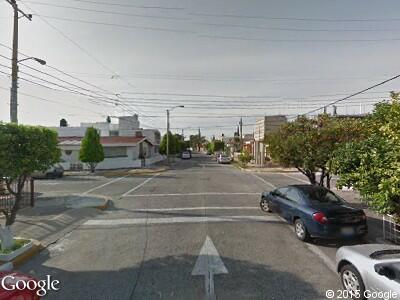

In [9]:
##使用文本检索
query_str = 'a building on the side of street in Singapore?'

##使用图像检索
img_path = '20.672456_-103.411312_514135aafdc9f04926004ab6_Guadalajara.JPG'
Image.open(img_path)

**Node ID:** 6c04ba86-1cbe-48ec-ac29-af61550ae849<br>**Similarity:** 0.7716575786978164<br>**Text:** a city street with cars parked on the side of the road and a building on the side of the road<br>**Image:**

**Node ID:** 328e1660-24cf-4941-8ccc-0642a02cffc5<br>**Similarity:** 0.7639110413080502<br>**Text:** a city street with cars parked on the side of the road and a building on the side of the road<br>**Image:**

**Node ID:** ac760741-0202-438d-a5ef-ef69e6f9182a<br>**Similarity:** 0.7604974317842903<br>**Text:** a city street with trees and a street sign on the side of the road with a building behind it<br>**Image:**

[0.7716575786978164, 0.7639110413080502, 0.7604974317842903]


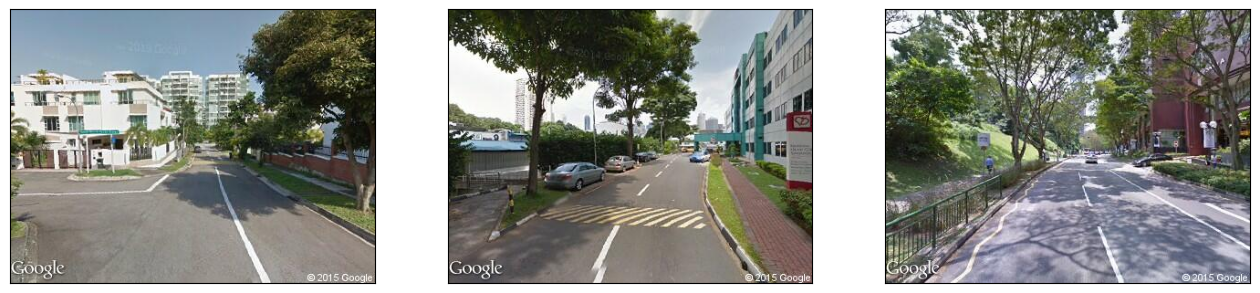

In [19]:
query_str = 'a building on the side of street in Singapore?'
img_path = '20.672456_-103.411312_514135aafdc9f04926004ab6_Guadalajara.JPG'

img, txt, score, metadata = retrieve_display(urban_retrieve.retrieve(query_str))  ##多模态检索

# img, txt, score, metadata = retrieve_display(urban_retrieve.image_to_image_retrieve(img_path))  ##图像到图像检索

# img, txt, score, metadata = retrieve_display(urban_retrieve.text_to_image_retrieve(img_path))  ##文本到图像检索

##将检索完成的图像/本文/元数据储存在这里
image_documents = [ImageDocument(image_path=img_path)]
for res_img in img:
    image_documents.append(ImageDocument(image_path=res_img))
context_str = "".join(txt)
metadata_str = metadata

##可视化一下
print(score)
plot_images(img)  ## visualization

## 5.创建llm生成回答

In [21]:
##创建简单的llm，不包含检索信息
response = mm_model.complete(
    prompt="a building on the side of street in Singapore?",
    image_documents=image_documents
    )

print(response)

#  print-->  The image shows a street scene with an apartment building on the left side. It's a multi-story structure with balconies, likely part of a residential area in Singapore. However, without more context or details from the image, it is not possible to confirm whether this building is indeed located in Singapore or if it is representative of typical housing in another region that resembles Singapore in terms of architecture and layout. 

 The image shows a street scene with an apartment building on the left side. It's a multi-story structure with balconies, likely part of a residential area in Singapore. However, without more context or details from the image, it is not possible to confirm whether this building is indeed located in Singapore or if it is representative of typical housing in another region that resembles Singapore in terms of architecture and layout. 


In [22]:
##使用prompt，融入检索信息进行生成回答
## LLM templet
qa_tmpl_str = (
    "Given the provided information, including retrieved contents and metadata, \
     accurately and precisely answer the query without any additional prior knowledge.\n"
    "Please ensure honesty and responsibility, refraining from any racist or sexist remarks.\n"
    "---------------------\n"
    "Context: {context_str}\n"     ## 将上下文信息放进去
    "Metadata: {metadata_str} \n"  ## 将原始的meta信息放进去
    "---------------------\n"
    "Query: {query_str}\n"
    "Answer: "
)
query_str = 'a building on the side of street in Singapore?'

## use'.complete' invoke LLM
response = mm_model.complete(
    prompt=qa_tmpl_str.format(
        context_str=context_str,
        metadata_str=metadata_str,
        query_str=query_str, 
        ),
    image_documents=image_documents,
    )

In [24]:
response.text

# print--> ' Yes, there is a building on the side of the street in the image. It appears to be a multi-story residential or commercial building situated near the roadway. '

' Yes, there is a building on the side of the street in the image. It appears to be a multi-story residential or commercial building situated near the roadway. '